In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from tqdm import tqdm
import time

# Toy Dataset

In [184]:
def get_toy_logistic_regression_dataset(num_samples, num_features, cutoff):
    X = np.random.rand(num_samples, num_features)

    y = np.zeros(num_samples)
    y[X[:, 0] < 0.5] = 1

    return X, y

In [185]:
num_samples = 500
num_features = 1
cutoff = 0.5

X, y = get_toy_logistic_regression_dataset(num_samples, num_features, cutoff)

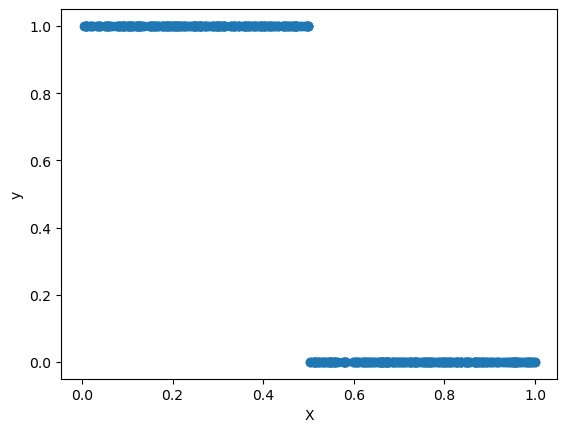

In [186]:
if num_features == 1:
    plt.scatter(x=X, y=y)
    plt.xlabel('X')
    plt.ylabel('y')

# Model

In [187]:
class LogisticRegressionModel():
    def __init__(self, num_features):
        self.num_features = num_features
        self.b = np.random.rand(1)
        self.w = np.random.rand(num_features)
        self.params = {'w': self.w, 'b': self.b}

    # functions and their derivatives
    
    def _sigmoid(self, z):
        # numerically stable; resistant to overflow
        # about 2.5 x slower than normal sigmoid
        positive_mask = z >= 0
        negative_mask = z <= 0
    
        y_hat = np.empty_like(z)
    
        y_hat[positive_mask] = 1. / (1 + np.exp(-z[positive_mask]))
    
        exp_z = np.exp(z[negative_mask])
        y_hat[negative_mask] = exp_z / (1 + exp_z)
        
        return y_hat

    def _cross_entropy(self, y, y_hat):
        # do I even need this function?
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def _cross_entropy_stable(self, y, z):
        # Takes in raw logits
        stable_mask = z <= 20
        unstable_mask = ~stable_mask
        
        cross_entropy_loss = np.empty_like(z)

        # for large z (in this case >= 20), log(e^z + 1) can be approximated by z. This makes loss calculation robust to overflow
        cross_entropy_loss[stable_mask] = np.log(np.exp(z[stable_mask]) + 1) - (y[stable_mask]* z[stable_mask])
        cross_entropy_loss[unstable_mask] = z[unstable_mask] - (y[unstable_mask] * z[unstable_mask])
        
        return cross_entropy_loss

    def _cross_entropy_stable_derivative(self, y, z):
        # ... Also takes in raw logits
        stable_mask = z <= 20
        unstable_mask = ~stable_mask
        
        d_z = np.empty_like(z)

        # derivatives based on piecewise function defined in _cross_entropy_stable
        d_z[stable_mask] = (np.exp(z[stable_mask]) / (np.exp(z[stable_mask]) + 1)) - y[stable_mask] # could make more efficient
        d_z[unstable_mask] = 1 - y[unstable_mask]
        
        return d_z

    def _compute_gradients(self, X, y):
        # d_parameters w.r.t. cross entropy loss
        z = np.dot(X, self.w) + self.b
        d_z = self._cross_entropy_stable_derivative(y, z)
        d_w = np.dot(X.T, d_z) / d_z.shape[0]
        d_b = np.mean(d_z)
        return d_w, d_b

    def _fit_gd(self, X, y):
        # standard gradient descent
        lr = 0.75  # play w this
        lr_decay_rate = 0.99999 # and this
        
        for i in tqdm(iterable=range(10_000), desc='Fitting model'):
            d_w, d_b = self._compute_gradients(X, y)

            self.w -= (d_w * lr)
            self.b -= (d_b * lr)

            lr *= lr_decay_rate

    def _fit_sgd(self, X, y):
        # stochastic gradient descent

        lr = 0.75  # play w this
        lr_decay_rate = 0.99999 # and this
        
        # make batches
        num_batches = 50
        
        x_batches = np.array(np.array_split(X, num_batches))
        y_batches = np.array(np.array_split(y, num_batches))

        batch_idx = 0

        for i in tqdm(iterable=range(10_000), desc='Fitting model'):
            x_batch = x_batches[batch_idx]
            y_batch = y_batches[batch_idx]
            
            d_w, d_b = self._compute_gradients(x_batch, y_batch)

            self.w -= (d_w * lr)
            self.b -= (d_b * lr)

            lr *= lr_decay_rate

            batch_idx = (batch_idx + 1) % num_batches

    def fit(self, X, y, solver='GD', shuffle=True):
        if shuffle:
            pass
            # TODO need to find a way to shuffle X and y together so they don't get fucked up
        
        if solver == 'GD':
            self._fit_gd(X, y)

        elif solver == "SGD":
            self._fit_sgd(X, y)

        elif solver == 'SAG':
            raise NotImplementedError('stochastic average gradient not yet implemented')

        else:
            raise ValueError(f'"{solver}" is not a valid solver. Choose one of "GD", "SGD", or "SAG"')
        
    def loss(self, X, y):
        z = np.dot(X, self.w) + self.b
        cross_entropy_loss = self._cross_entropy_stable(y, z)
        return cross_entropy_loss.mean()

    def accuracy(self, X, y):
        y_hat = self.__call__(X)
        
        model_prediction = np.empty_like(y_hat)
        model_prediction[y_hat > 0.5] = 1
        model_prediction[y_hat < 0.5] = 0
        
        num_correct = np.sum(model_prediction == y)

        p_correct = num_correct / len(y)
        
        return p_correct

    def __call__(self, X):
        return self._sigmoid(np.dot(X, self.w) + self.b)

# Create and Fit Model

Text(0, 0.5, 'y')

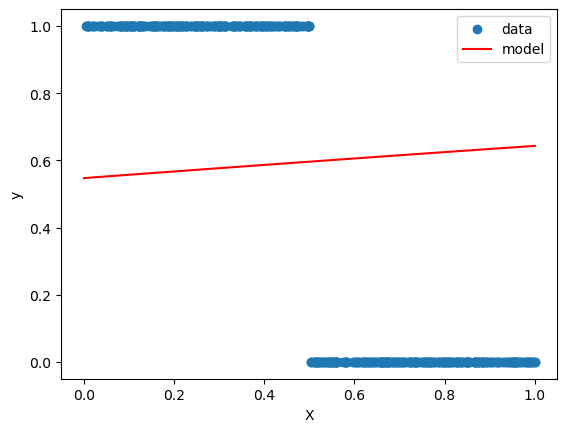

In [203]:
model=LogisticRegressionModel(num_features)

plt.scatter(X, y)
plt.plot(np.linspace(0, 1, 100), model(np.linspace(0, 1, 100).reshape(-1, 1)), color='r')
plt.legend(['data', 'model'])
plt.xlabel('X')
plt.ylabel('y')

In [204]:
print(f'cross entropy loss: {model.loss(X, y)}, accuracy:  {model.accuracy(X, y)}')

start = time.time()
model.fit(X, y, solver='GD')
print(time.time() - start)

print(f'cross entropy loss: {model.loss(X, y)}, accuracy:  {model.accuracy(X, y)}')

cross entropy loss: 0.7596163726242748, accuracy:  0.508


Fitting model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 45047.49it/s]

0.2281351089477539
cross entropy loss: 0.05443258390357121, accuracy:  1.0


Text(0, 0.5, 'y')

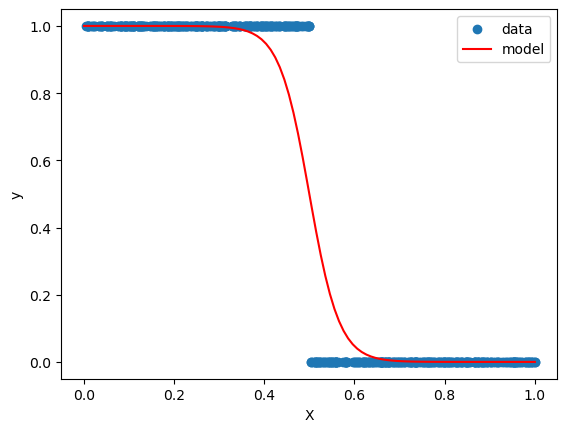

In [197]:
plt.scatter(X, y)
plt.plot(np.linspace(0, 1, 100), model(np.linspace(0, 1, 100).reshape(-1, 1)), color='r')
plt.legend(['data', 'model'])
plt.xlabel('X')
plt.ylabel('y')

# sklearn

In [112]:
from sklearn.linear_model import LogisticRegression

In [159]:
sklearn_model = LogisticRegression()

In [160]:
start = time.time()
sklearn_model.fit(X, y)
print(time.time() - start)

0.007139682769775391


Text(0, 0.5, 'y')

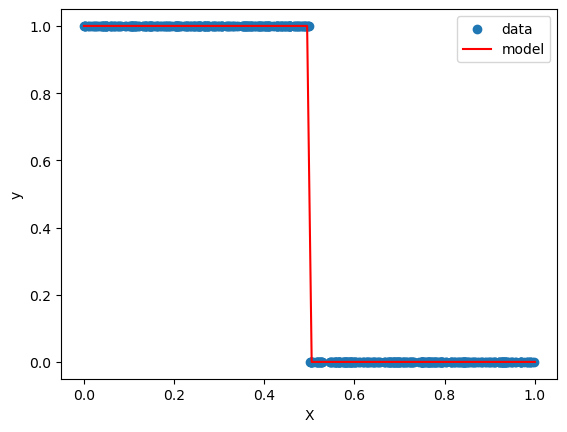

In [161]:
plt.scatter(X, y)
plt.plot(np.linspace(0, 1, 100), sklearn_model.predict(np.linspace(0, 1, 100).reshape(-1, 1)), color='r')
plt.legend(['data', 'model'])
plt.xlabel('X')
plt.ylabel('y')

# random BS

In [176]:
# inplace
np.random.shuffle(np.array([X, y]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 500) + inhomogeneous part.

In [174]:
X

array([[1.49419110e-01],
       [8.42171795e-01],
       [2.59774193e-01],
       [2.85332865e-01],
       [6.34769903e-01],
       [7.47480468e-01],
       [2.85138443e-01],
       [1.76542188e-01],
       [2.43891773e-01],
       [6.84912548e-01],
       [1.94507965e-01],
       [5.28874904e-01],
       [4.51419433e-01],
       [5.83608827e-01],
       [8.20875860e-01],
       [1.05904319e-01],
       [2.57355737e-01],
       [8.81207219e-01],
       [3.36404352e-01],
       [7.49658555e-01],
       [9.46659050e-01],
       [6.91718447e-01],
       [2.33007233e-03],
       [5.16990406e-01],
       [5.91505717e-01],
       [5.28983173e-01],
       [1.00753908e-01],
       [4.81230071e-01],
       [5.90457887e-01],
       [5.60545822e-01],
       [4.78225832e-02],
       [1.11548691e-01],
       [2.54574193e-01],
       [5.02664840e-01],
       [9.83017545e-01],
       [8.72765809e-01],
       [8.42153843e-01],
       [3.05286094e-01],
       [4.57636515e-01],
       [1.43819846e-01],
